# Load libraries & parameters

In [1]:
%matplotlib inline
import itertools as it
from sklearn.impute import KNNImputer
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import seaborn as sns
import scipy.cluster.hierarchy as spc
from sklearn.model_selection import train_test_split
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BitFlipMutation, SPXCrossover, BinaryTournamentSelection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import PrintObjectivesObserver
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import datetime
import pickle
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn import preprocessing
from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from jmetal.core.problem import BinaryProblem
from jmetal.core.solution import BinarySolution
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

Using TensorFlow backend.


In [20]:
load_saved_data = False
load_saved_model = False

# parameter
n_neighbors = 3
null_percentage = 0.1
test_ratio = 0.2
random_state = 1
weights = [1/3, 1/3, 1/3]
# 0 CLFS / 1 CFS / 2 PCA
feature_selection = 2
evaluations = 20000

dir_dataset = 'dataset/'
dir_prepro = 'prepro/'
dir_featsel = 'featsel/'
dir_model = 'model/'

## Functions

In [107]:
def drop_constant_column(dataframe):
    for column in dataframe.columns:
        unique = dataframe[column].unique()
        unique = unique[~np.isnan(unique)]
        if len(unique) == 1:
            dataframe.drop(column,inplace=True,axis=1)
    return dataframe

def normalize_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(data.values)
    data_norm = pd.DataFrame(x_scaled, columns=data.columns, index=data.index)
    return data_norm

def correlation_figure(corrmat, title):    
    all_correlation = corrmat.values
    feat_to_feat_corr = corrmat.iloc[:-1, :-1]
    feat_to_label_corr = corrmat.iloc[:-1, -1]
    
    # plot only top 100
    fig = feat_to_label_corr.nlargest(100).plot(kind='barh', figsize=(20, 20)).get_figure()
    fig.show()

    if not load_saved_data:
        fig.savefig(dir_featsel+'feat_to_label_corr_{}.png'.format(title))
        
    #plot heat map
    plt.figure(figsize=(20,20))
    # tick labelnya lompat2 biar muat
    g=sns.heatmap(feat_to_feat_corr, vmin=0, vmax=1,cmap="RdYlGn")

    if not load_saved_data:
        plt.savefig(dir_featsel+'feat_to_feat_corr_{}.png'.format(title))
    
    
def load_latency_data(title):
    latency_data = pd.read_csv(dir_dataset+title)
    latency_data = latency_data.drop(['Column'], axis = 1)
    return latency_data

def test_model(clf, x, y, title):
    print('Test on {}'.format(title))
    labels = ['Pass', 'Fail']
    if 'all' in title or 'edge' in title or 'cloud' in title:
        y_pred = clf.predict_classes(x)
    else:
        y_pred = clf.predict(x)
    
    # Confusion matrix and classification report
    matrix = confusion_matrix(y, y_pred)
    g=sns.heatmap(matrix,annot=True,cbar=False, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion matrix of {}'.format(title))
    
    if not load_saved_model:
        plt.savefig(dir_model+'conmatrix-{}.png'.format(title))
    plt.show()
    plt.close()
    
    counts = y.value_counts()
    print(counts)
    info = 'Scenario : {}\n'.format(title)
    if 'test' in title:
        info += 'Pass/Fail : {}/{}\n'.format(counts[0], counts[1])
    else:
        info += 'Pass : {}\n'.format(counts[0])    
    info += classification_report(y, y_pred, target_names=labels)
    print(info)
    
    if not load_saved_model:
        f = open(dir_model+'test-{}.txt'.format(title), 'w')
        f.write(info)
    
def train_model(x, y, title):
    if not load_saved_model:
        clf = Sequential()
        clf.add(Dense(64, input_dim=x.shape[1], activation='relu'))
        clf.add(Dense(32, activation='relu'))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        stringlist = []
        clf.summary(print_fn=lambda x: stringlist.append(x))
        short_model_summary = "\n".join(stringlist)
        print(short_model_summary)

        f = open(dir_model+'summary-{}.txt'.format(title), 'w')
        f.write(short_model_summary)
        
        plot_model(clf, to_file=dir_model+'model_{}.png'.format(title))
        
        clf.fit(x, y, epochs=100) 
        clf.save(dir_model+'model_{}.h5'.format(title))
    else:
        clf = load_model(dir_model+'model_{}.h5'.format(title))
    
    return clf

# Load dataset

In [4]:
#  reading the data
data_ori = pd.read_csv(dir_dataset+'uci-secom.csv')
data_ori = data_ori.drop(['Time'], axis = 1)
data_ori.loc[data_ori['Fault'] == 1, 'Fault'] = 1
data_ori.loc[data_ori['Fault'] == -1, 'Fault'] = 0

output_labels = data_ori['Fault'].value_counts()
fault_fraction = output_labels[1]/float(output_labels[0])
n_all_data = len(data_ori)
n_pass_data = output_labels[0]
n_fail_data = output_labels[1]
print('fault_fraction', fault_fraction)
print('total data', n_all_data)
print('pass data', n_pass_data)
print('fail data', n_fail_data)

fault_fraction 0.0710868079289132
total data 1567
pass data 1463
fail data 104


In [10]:
data_ori.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [11]:
data_ori.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,0.066369
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,0.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


# Preprocessing

## Data cleaning

In [12]:
if not load_saved_data:
    # Drop columns with constant value
    data_clean = drop_constant_column(data_ori)

    # Only keep columns with NaN values below percentage
    data_clean = data_clean.loc[:, data_clean.isnull().mean() < null_percentage]

    # print precentage of NaN value in each coloumn
    print(data_clean.isnull().mean())

    data_clean.head()

0        0.003829
1        0.004467
2        0.008934
3        0.008934
4        0.008934
           ...   
586      0.000638
587      0.000638
588      0.000638
589      0.000638
Fault    0.000000
Length: 423, dtype: float64


## Data imputation

In [13]:
if not load_saved_data:
    # data.replace(np.nan, 0, inplace = True)
    # imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit(data_clean)
    data_impu = pd.DataFrame(imputer.transform(data_clean), columns=data_clean.columns)

    print("Is there any null?", data_impu.isnull().any().any())

Is there any null? False


## Data normalization

In [14]:
if not load_saved_data:
    data_norm = normalize_data(data_impu)

In [21]:
if not load_saved_data:
    data_prepro = data_norm
    data_prepro.to_pickle(dir_prepro+'data_prepro.pkl')
else:
    data_prepro = pd.read_pickle(dir_prepro+'data_prepro.pkl')

x_all = data_prepro.iloc[:, :-1]
y_all = data_prepro.iloc[:, -1]

## Data sampling

In [22]:
if not load_saved_data:
    sm = SMOTE(random_state=1)
    x_sample, y_sample = sm.fit_resample(x_all, y_all)
    data_prepro_sample = pd.concat([x_sample, y_sample], axis=1)
    data_prepro_sample.to_pickle(dir_prepro+'data_prepro_sample.pkl')
else:
    data_prepro_sample = pd.read_pickle(dir_prepro+'data_prepro_sample.pkl')
    x_sample = data_prepro_sample.iloc[:, :-1]
    y_sample = data_prepro_sample.iloc[:, -1]

In [23]:
data_prepro_sample['Fault'].value_counts()

1.0    1463
0.0    1463
Name: Fault, dtype: int64

## Dataset splitting

In [24]:
x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(x_sample, y_sample, test_size=test_ratio, random_state=random_state)

# Correlation & Latency aware Feature Selection

## Get correlation coefficient

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\ipykernel_launcher.py:22: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



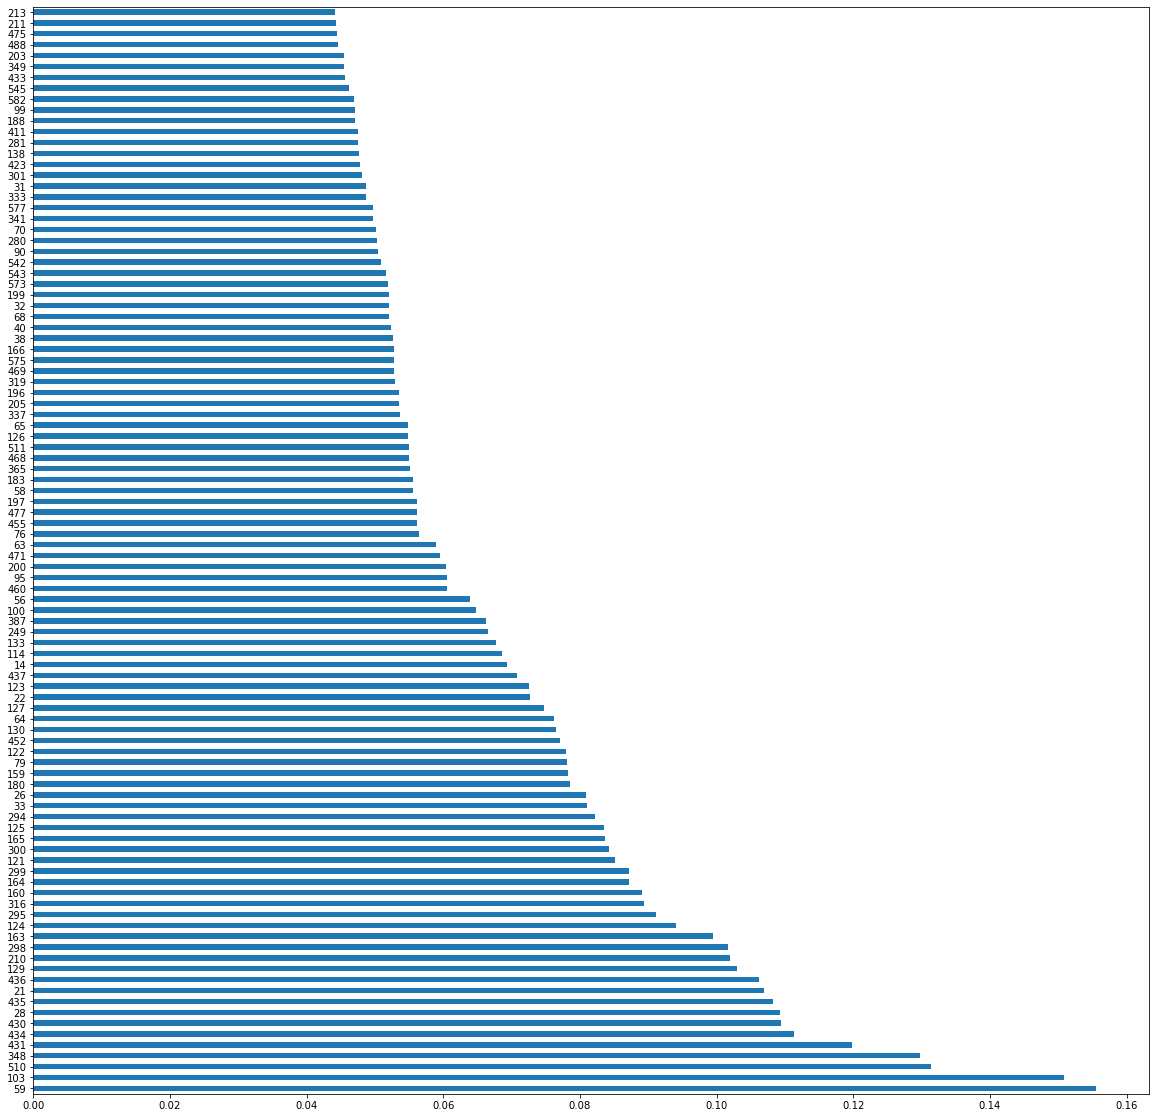

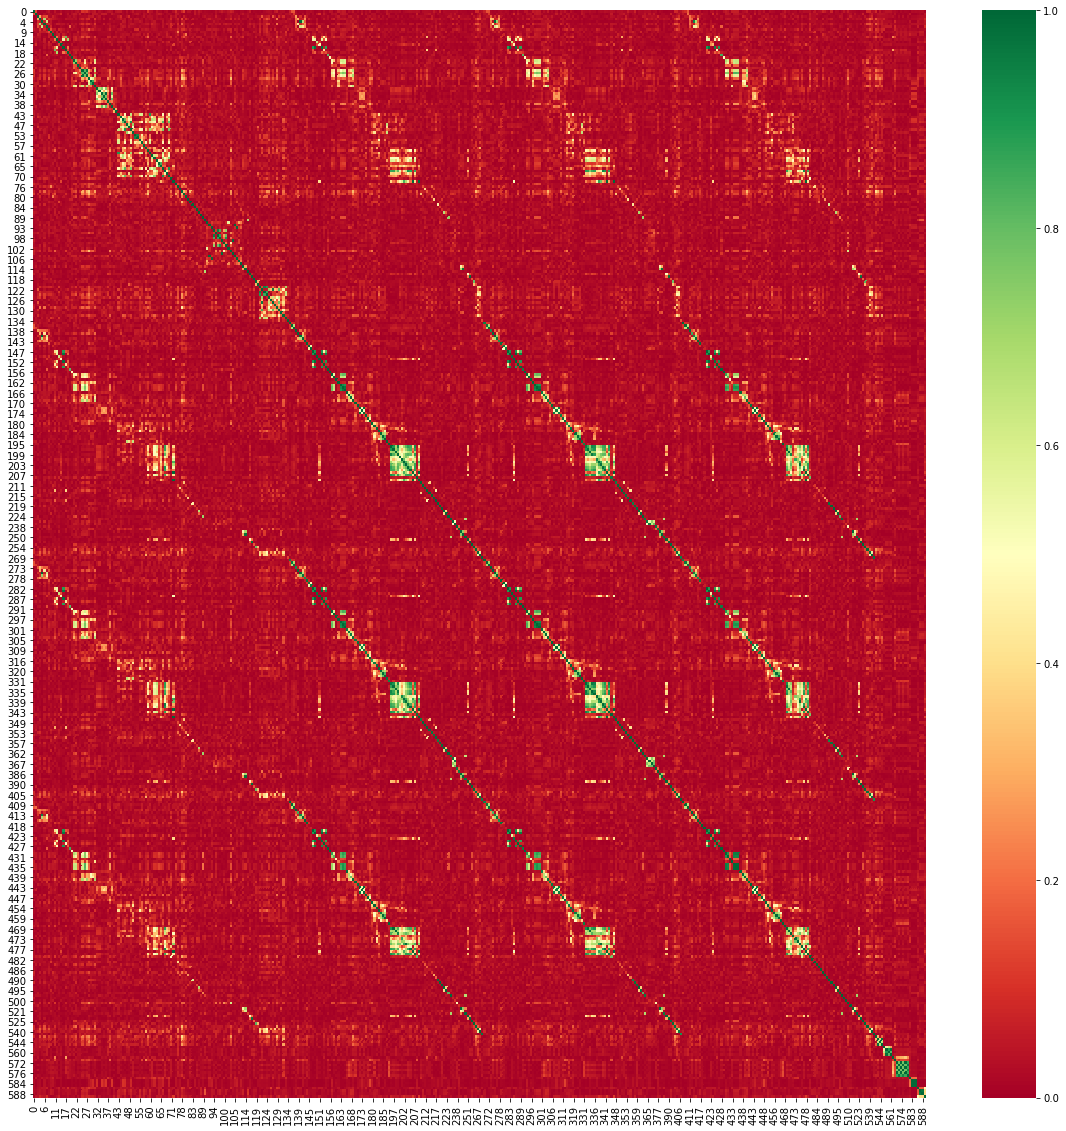

In [25]:
corrmat = abs(data_prepro.corr())
correlation_figure(corrmat, 'prepro')

## Get latency scale

In [26]:
edge_latency = load_latency_data('edge_latency.csv')
scaled_edge_latency = normalize_data(edge_latency)

cloud_latency = load_latency_data('cloud_latency.csv')
scaled_cloud_latency = normalize_data(cloud_latency)

In [27]:
edge_latency.head()

,Latency
0,6.010
1,2.966
2,5.988
3,8.987
4,6.967


In [28]:
scaled_edge_latency.head()

,Latency
0,0.455727
1,0.179000
2,0.453727
3,0.726364
4,0.542727


## Genetic algorithm

In [29]:
# Feature correlation selection
class CLFS(BinaryProblem):

    def __init__(self, correlation, latency, features, weights, use_latency):
        super(CLFS, self).__init__()

        self.correlation = correlation
        self.latency = latency
        self.use_latency = use_latency
        self.features = features
        self.weights = weights
        self.number_of_bits = len(features)
        
        # Minimization to find most independent between variable 
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = 1
        self.number_of_objectives = 1
        self.number_of_constraints = 0

    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # List selected features
        feats = []
        for idx, bits in enumerate(solution.variables[0]):
            if bits:
                feats.append(str(self.features[idx]))
                
        # calculate label correlation
        label_corr = 0
        for j in feats:
            label_corr += (1-self.correlation[j][-1])
        label_corr = label_corr/len(feats)

        # calculate feature correlation
        feat_corr = 0
        comb = list(it.combinations(feats, 2))
        for j in comb:
            feat_corr += self.correlation[j[0]][j[1]]
        feat_corr = feat_corr/len(comb)
        
        if self.use_latency:
            # calculate latency scale
            latency_scale = 0
            for j in feats:
                latency_scale += float(self.latency.iloc[int(j)])
            latency_scale = latency_scale/len(feats)

        if self.use_latency:
            fitness = (weights[0]*label_corr) + (weights[1]*feat_corr) + (weights[2]*latency_scale)
        else:
            fitness = (label_corr/2) + (feat_corr/2)
        
        solution.objectives[0] = fitness

        return solution

    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables, number_of_objectives=self.number_of_objectives)
        new_solution.variables[0] = [True if random.randint(0, 1) == 1 else False for _ in range(self.number_of_bits)]
        return new_solution
    
    def get_name(self):
        if self.use_latency:
            return 'CLFS'
        else:
            return 'CFS'

In [30]:
def clfs_ga(corrmat, scaled_latency, features, weights, title, use_latency):
    problem = CLFS(corrmat, scaled_latency, features, weights, use_latency)

    algorithm = GeneticAlgorithm(
            problem=problem,
            population_size=100,
            offspring_population_size=100,
            mutation=BitFlipMutation(1.0 / problem.number_of_bits),
            crossover=SPXCrossover(0.8),
            selection=BinaryTournamentSelection(),
            termination_criterion=StoppingByEvaluations(max=evaluations)
        )

    algorithm.observable.register(observer=PrintObjectivesObserver())

    algorithm.run()

    variables = x_all.columns[result.variables[0]]
    
    info = '\nAlgorithm: {}'.format(algorithm.get_name())
    info += '\nProblem: CLFS using {} latency'.format(title)
    info += '\nNumber of features: {}'.format(len(variables))
    info += '\nFitness: {}'.format(result.objectives[0])
    info += '\nComputing time: {}'.format(algorithm.total_computing_time)
    print(info)
    
    if not load_saved_data:    
        f = open(dir_featsel+'ga_info_{}.txt'.format(title), 'w')
        f.write(info)
    
    return variables

## Execute on Feature selection on Edge

In [91]:
if feature_selection==0 or feature_selection==1:
    print('CLFS: use latency' if feature_selection==0 else 'CFS: not use latency')
    title_fs = 'edge_clfs' if feature_selection==0 else 'edge_cfs'
    if not load_saved_data:
        variables_edge = clfs_ga(corrmat, scaled_edge_latency, x_all.columns, weights, title,
                                 True if feature_selection==0 else False)
        with open('{}variables_{}.pkl'.format(dir_featsel, title), 'wb') as filename:
            pickle.dump(variables_edge, filename) 
    else:
        with open('{}variables_{}.pkl'.format(dir_featsel, title), 'rb') as pickle_file:
            variables_edge = pickle.load(pickle_file)
    print(variables_edge.shape)
                        
elif feature_selection==2:
    print('PCA')
    title_fs = 'edge_pca'
    if not load_saved_data:
        # pca - keep 90% of variance
        # select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified.
        pca = PCA(0.9)
        pca.fit(x_all)
        
        x_train_pca = pca.transform(x_train_sample)
        x_test_pca = pca.transform(x_test_sample)
        
        x_train_pca = pd.DataFrame(x_train_pca)
        x_test_pca = pd.DataFrame(x_test_pca)
        
        x_train_pca.to_pickle(dir_featsel+'x_train_pca.pkl')
        x_test_pca.to_pickle(dir_featsel+'x_test_pca.pkl')
    else:
        x_train_pca = pd.read_pickle(dir_featsel+'x_train_pca.pkl')
        x_test_pca = pd.read_pickle(dir_featsel+'x_test_pca.pkl')
    print(x_train_pca.shape)

PCA
(2340, 96)


C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\ipykernel_launcher.py:22: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



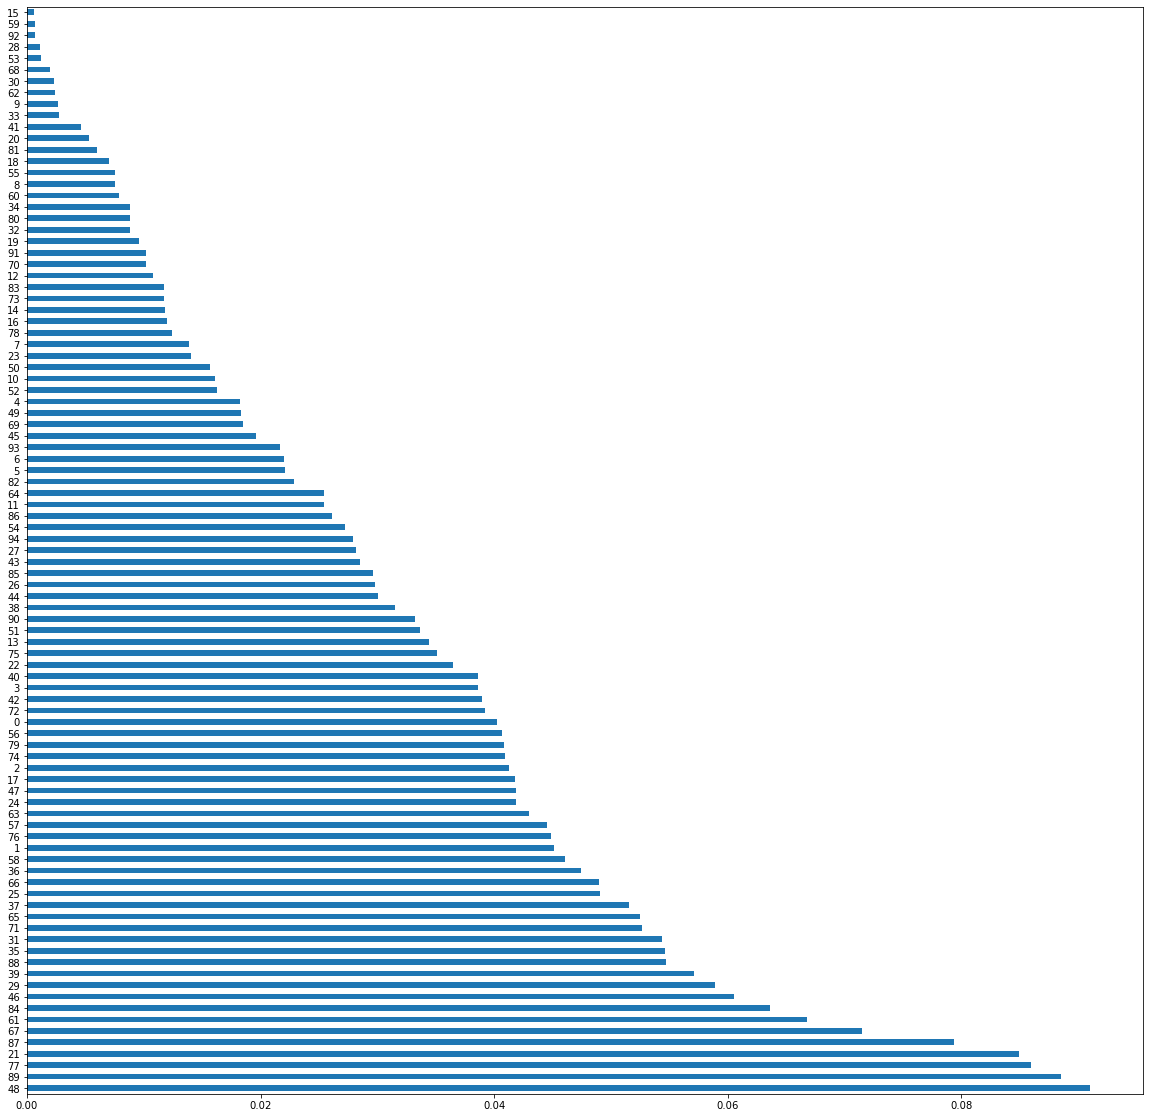

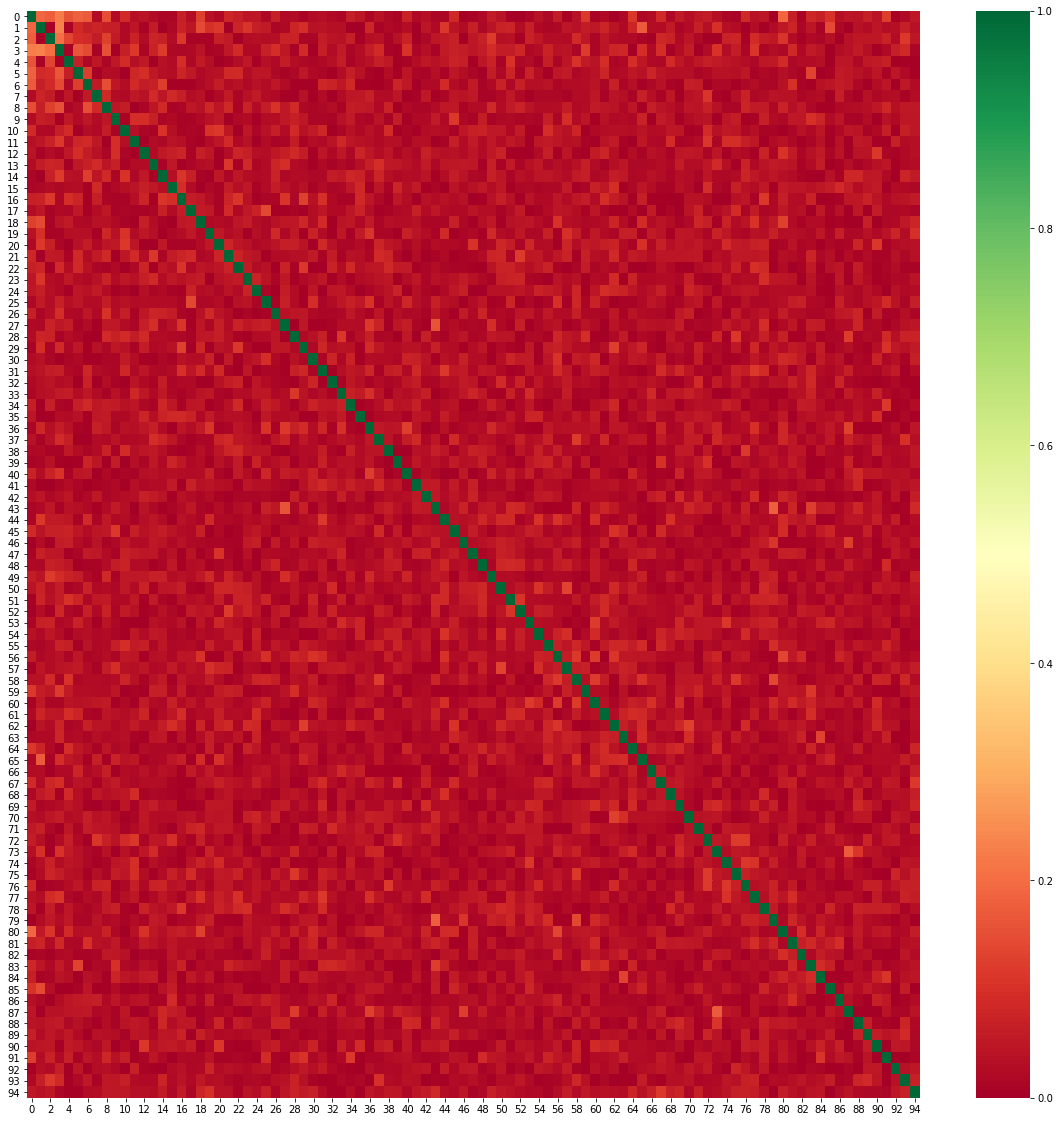

In [92]:
if feature_selection==0 or feature_selection==1:
    sel_variables_edge = [str(i) for i in variables_edge]
    sel_variables_edge.append('Fault')
    sel_data_edge = data_prepro.loc[:, sel_variables_edge]
else:
    sel_data_edge = x_train_pca

sel_corrmat_edge = abs(sel_data_edge.corr())
correlation_figure(sel_corrmat_edge, title_fs)

## Execute on CLFS Cloud

In [ ]:
if not load_saved_data:
    variables_cloud = clfs_ga(corrmat, scaled_cloud_latency, x_all.columns, weights, 'cloud', True)
    with open(dir_featsel+'variables_cloud.pkl', 'wb') as filename:
        pickle.dump(variables_cloud, filename)
else:
    with open(dir_featsel+'variables_cloud.pkl', 'rb') as pickle_file:
        variables_cloud = pickle.load(pickle_file)

In [ ]:
sel_variables_cloud = [str(i) for i in variables_cloud]
sel_variables_cloud.append('Fault')
sel_data_cloud = data_prepro.loc[:, sel_variables_cloud]

sel_corrmat_cloud = abs(sel_data_cloud.corr())
correlation_figure(sel_corrmat_cloud, 'cloud')

# Training & Test

## Model - all features

In [ ]:
x_train_sample.shape

In [ ]:
clf_all = train_model(x_train_sample, y_train_sample, 'all')

In [ ]:
# test_model(clf_all, x_train_sample, y_train_sample, 'train_all')
test_model(clf_all, x_test_sample, y_test_sample, 'test_all')

## NN - CLFS cloud

In [ ]:
x_train_sel_cloud = x_train_sample.loc[:, variables_cloud]
x_test_sel_cloud = x_test_sample.loc[:, variables_cloud]
x_train_sel_cloud.shape

In [ ]:
clf_cloud = train_model(x_train_sel_cloud, y_train_sample, 'cloud')

In [ ]:
# test_model(clf_cloud, x_train_sel_cloud, y_train_sample, 'train_cloud')
test_model(clf_cloud, x_test_sel_cloud, y_test_sample, 'test_cloud')

## NN - CLFS edge

In [101]:
if feature_selection==0 or feature_selection==1:
    x_train_sel_edge = x_train_sample.loc[:, variables_edge]
    x_test_sel_edge = x_test_sample.loc[:, variables_edge]
else:
    x_train_sel_edge = x_train_pca
    x_test_sel_edge = x_test_pca
x_train_sel_edge.shape

(2340, 96)

In [108]:
clf_edge = train_model(x_train_sel_edge, y_train_sample, title_fs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________


Test on test_edge_pca


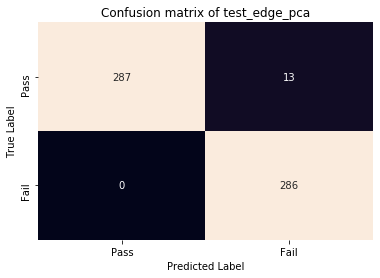

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_edge_pca
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       1.00      0.96      0.98       300
        Fail       0.96      1.00      0.98       286

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



In [95]:
# test_model(clf_edge, x_train_sel_edge, y_train_sample, 'train_'+title_fs)
test_model(clf_edge, x_test_sel_edge, y_test_sample, 'test_'+title_fs)

## ML - CLFS edge

In [98]:
with open(dir_featsel+'variables_edge_clfs.pkl', 'rb') as pickle_file:
    variables_edge_ml = pickle.load(pickle_file)
x_train_sel_edge = x_train_sample.loc[:, variables_edge_ml]
x_test_sel_edge = x_test_sample.loc[:, variables_edge_ml]
x_train_sel_edge.shape

(2340, 45)

Test on test_lr


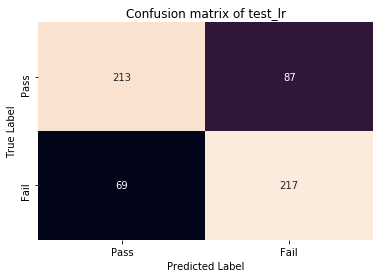

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_lr
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       0.76      0.71      0.73       300
        Fail       0.71      0.76      0.74       286

    accuracy                           0.73       586
   macro avg       0.73      0.73      0.73       586
weighted avg       0.74      0.73      0.73       586

Test on test_svm


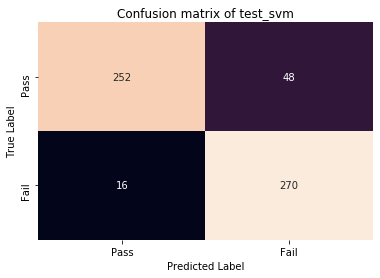

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_svm
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       0.94      0.84      0.89       300
        Fail       0.85      0.94      0.89       286

    accuracy                           0.89       586
   macro avg       0.89      0.89      0.89       586
weighted avg       0.90      0.89      0.89       586

Test on test_knn


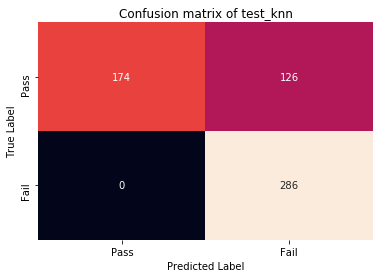

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_knn
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       1.00      0.58      0.73       300
        Fail       0.69      1.00      0.82       286

    accuracy                           0.78       586
   macro avg       0.85      0.79      0.78       586
weighted avg       0.85      0.78      0.78       586

Test on test_dt


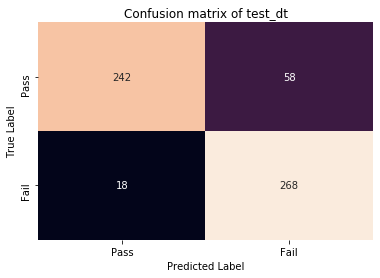

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_dt
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       0.93      0.81      0.86       300
        Fail       0.82      0.94      0.88       286

    accuracy                           0.87       586
   macro avg       0.88      0.87      0.87       586
weighted avg       0.88      0.87      0.87       586

Test on test_nb


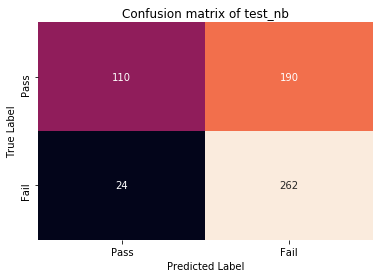

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_nb
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       0.82      0.37      0.51       300
        Fail       0.58      0.92      0.71       286

    accuracy                           0.63       586
   macro avg       0.70      0.64      0.61       586
weighted avg       0.70      0.63      0.61       586



In [99]:
if not load_saved_model:
    # LogisticRegression
    clf_lr = LogisticRegression().fit(x_train_sel_edge, y_train_sample)
    pickle.dump(clf_lr, open(dir_model+'model_lr.pkl', 'wb'))
    # Support vector machines
    clf_svm = svm.SVC().fit(x_train_sel_edge, y_train_sample)
    pickle.dump(clf_svm, open(dir_model+'model_svm.pkl', 'wb'))
    # KNeighborsClassifier
    clf_knn = KNeighborsClassifier(n_neighbors=3).fit(x_train_sel_edge, y_train_sample)
    pickle.dump(clf_knn, open(dir_model+'model_knn.pkl', 'wb'))
    # DecisionTreeClassifier
    clf_dt = DecisionTreeClassifier().fit(x_train_sel_edge, y_train_sample)
    pickle.dump(clf_dt, open(dir_model+'model_dt.pkl', 'wb'))
    # Naive Bayes
    clf_nb = GaussianNB().fit(x_train_sel_edge, y_train_sample)
    pickle.dump(clf_nb, open(dir_model+'model_nb.pkl', 'wb'))
    
else:
    clf_lr = pickle.load(open(dir_model+'model_lr.pkl', 'rb'))
    clf_svm = pickle.load(open(dir_model+'model_svm.pkl', 'rb'))
    clf_knn = pickle.load(open(dir_model+'model_knn.pkl', 'rb'))
    clf_dt = pickle.load(open(dir_model+'model_dt.pkl', 'rb'))
    clf_nb = pickle.load(open(dir_model+'model_nb.pkl', 'rb'))
    
test_model(clf_lr, x_test_sel_edge, y_test_sample, 'test_lr')
test_model(clf_svm, x_test_sel_edge, y_test_sample, 'test_svm')
test_model(clf_knn, x_test_sel_edge, y_test_sample, 'test_knn')
test_model(clf_dt, x_test_sel_edge, y_test_sample, 'test_dt')
test_model(clf_nb, x_test_sel_edge, y_test_sample, 'test_nb')